1. Выбери любую понравившуюся модель из 23.2 урока
2. Используя известный датасет котировок Apple, обучи модель. Выведи графики из урока: график процесса обучения, сопоставления базового и прогнозного рядов, а также график автокорреляции.
3. Для получения трех проходных баллов за урок скорректируй код урока для данных с batch_size не равному 1.
4. Хочешь 4 балла? Возьми полносвязанную модель или с одномерной сверткой. Добейся подбором параметров и выбором архитектуры идеального графика автокорреляции без холмиков, равномерно спадающих графиков эталонной и прогнозной автокорреляции, максимально близко друг к другу.
5. Для получения дополнительного балла тебе необходимо избавиться от тренда с помощью дифференцирования в датасете.
6. Еще один балл можно получить сверху, если догадаешься как на графике сопоставления базового и прогнозного рядов отобразить реальную дату, а не относительную.

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv
price = pd.read_csv("./AAPL.csv", index_col='Date', usecols=['Adj Close', 'Date'], parse_dates=['Date'])

--2025-01-12 12:31:06--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv’

AAPL.csv            100%[===================>] 182.17K   246KB/s    in 0.7s    

2025-01-12 12:31:08 (246 KB/s) - ‘AAPL.csv’ saved [186539/186539]



In [3]:
# Удаление тренда с помощью дифференцирования
price['Adj Close'] = price['Adj Close'].diff().fillna(0)

# Разделение данных на обучающую и тестовую выборки
train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]

# Нормировка данных
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)


In [4]:
# Параметры генератора
n_input = 14  # Размерность входных данных
n_features = 1  # Размерность выходных данных
BATCH_SIZE = 32  # Размер пакета

# Генератор для обучающей выборки
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)

# Генератор для валидационной выборки
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=BATCH_SIZE)

# Генератор для тестовой выборки
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]


In [5]:
# Создание модели LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=generator[0][0].shape[1:]))
lstm_model.add(Dense(10, activation='relu'))
lstm_model.add(Dense(n_features))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,921 (42.66 KB)

 Trainable params: 10,921 (42.66 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Обучение модели
history = lstm_model.fit(generator, validation_data=validator, epochs=20)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0194 - val_loss: 0.0383
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0193 - val_loss: 0.0385
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0167 - val_loss: 0.0384
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0178 - val_loss: 0.0385
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0224 - val_loss: 0.0386
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0288 - val_loss: 0.0388
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0233 - val_loss: 0.0391
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0232 - val_loss: 0.0387
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0269 - val_loss: 0.0386
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0239 - val_loss: 0.0394
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0272 - val_loss: 0.0387
Epoch 12/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0191 - 

In [7]:
# Функция для отображения графика обучения
def history_plot(history, title):
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [8]:
# Функция для отображения сопоставления базового и прогнозного рядов
def show_predict(y_pred, y_true, title=''):
    plt.figure(figsize=(14, 7))
    plt.plot(y_pred[1:], label='Прогноз')
    plt.plot(y_true[:-1], label='Базовый')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [9]:
# Функция для расчета предсказания
def get_pred(model, x_test, y_test, y_scaler):
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))
    y_test_unscaled = y_scaler.inverse_transform(y_test)
    return y_pred_unscaled, y_test_unscaled

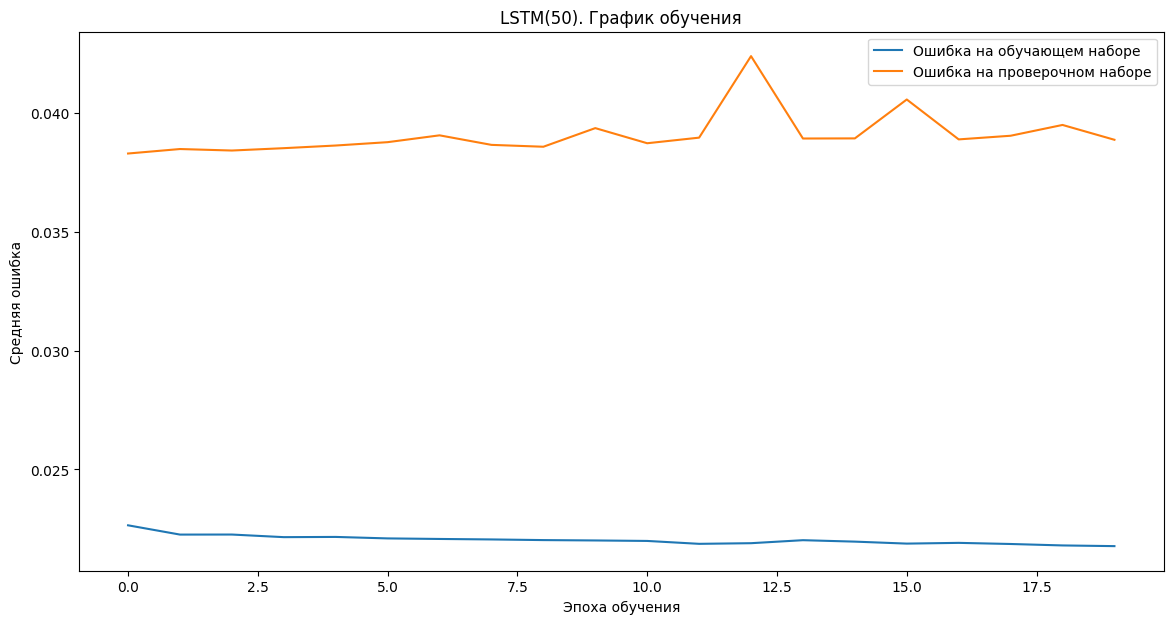

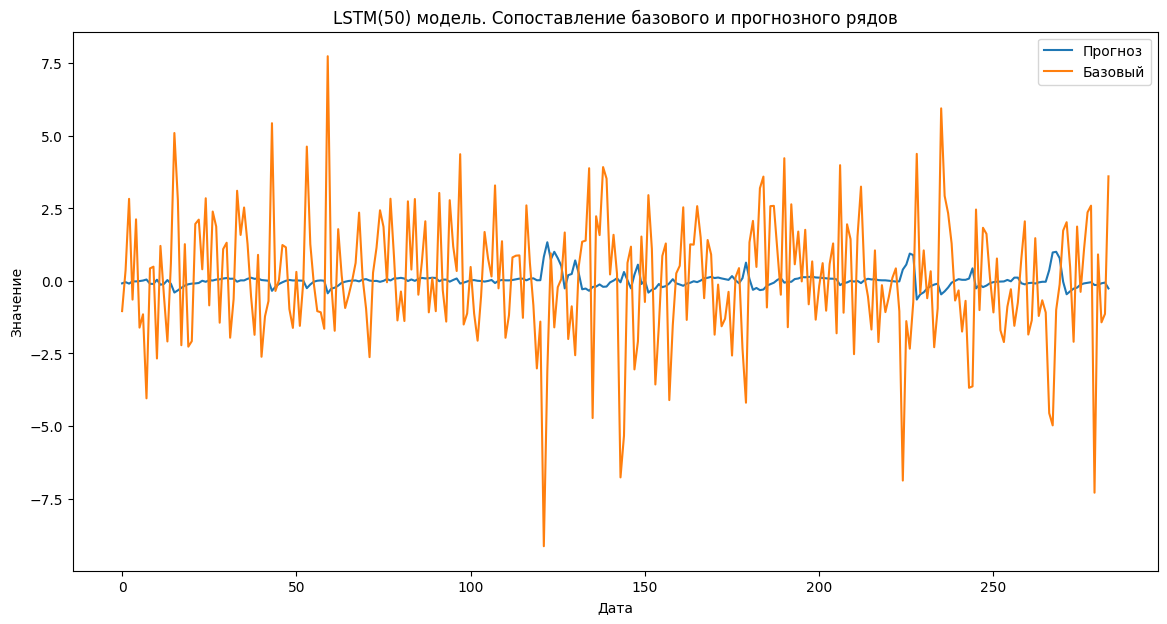

In [10]:
# Получение предсказания
y_pred, y_true = get_pred(lstm_model, x_test, y_test, scaler)

# Отображение графика обучения
history_plot(history, 'LSTM(50)')

# Отображение графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title='LSTM(50) модель. Сопоставление базового и прогнозного рядов')

# Функция для расчета корреляции
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция для отображения автокорреляции
def show_corr(y_pred, y_true, title='', break_step=30):
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len + 1, break_step + 1]))
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label='Прогноз')
    plt.plot(steps, auto_corr, label='Эталон')
    plt.title(title)
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

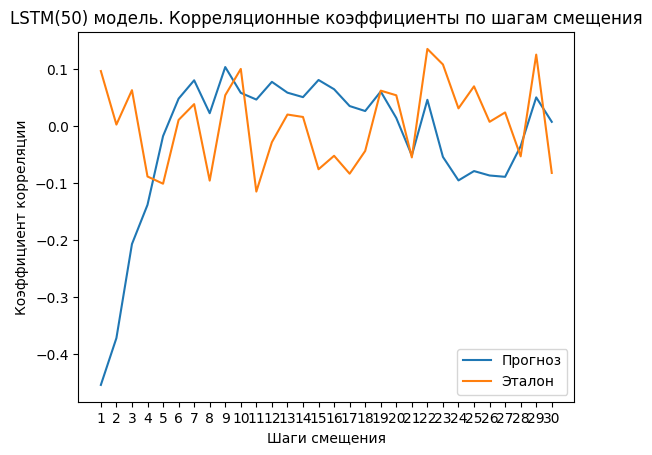

In [11]:
# Отображение графика автокорреляции
show_corr(y_pred, y_true, title='LSTM(50) модель. Корреляционные коэффициенты по шагам смещения')